<a href="https://colab.research.google.com/github/DibyB/Pix2Pix-TF-/blob/main/Pix2PixModel_TF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PIX2PIX TENSORFLOW MODEL**

Original paper: Image-to-Image Translation with Conditional Adversarial Networks

My sources:

**250 -** **Image to image translation using Pix2Pix** (https://www.youtube.com/watch?v=UcHe0xiuvpg)

**Pix2Pix using tensorflow** (https://www.tensorflow.org/tutorials/generative/pix2pix)

**Pix2Pix Paper Walkthrough**(https://www.youtube.com/watch?v=9SGs4Nm0VR4)



Understanding the basic structure:

1)Generator: It uses a U-Net architecture comprising of encoder and decoder using skip connections.

2)Discriminator: It uses PatchGan discriminator  that gives out the probability values (of how real it is) of several batches within the image so as to help the generator to make more realistic images.

**1) Importing the necessary libraries**





In [ ]:
import tensorflow as tf #neural network training framework

import os #operating system dependent tasks, such as data loading, creating logs and checkpoints and saving models
import pathlib #oop interface for working with file system paths
import time #functions related to time, such as tracking training time
import datetime #logging checkpoints and formatting timestamps

from matplotlib import pyplot as plt #to plot curves and see progress in data
from IPython import display #to display images or plots during training

**2) Loading the dataset (Facade dataset)**

In [ ]:
dataset_name = "facades"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 [==============================] - 11s 0us/step


In [ ]:
image_files = os.listdir(PATH)
print(image_files)

['test', 'train', 'val']


In [ ]:
# Define the path to the 'train' directory
train_path = PATH / 'train'

# List the files in the 'train' directory
train_files = os.listdir(train_path)

# Print the type of the files in the 'train' directory (usually a list)
print(f"Type of train_files: {type(train_files)}")

Type of train_files: <class 'list'>


In [ ]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

In [ ]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


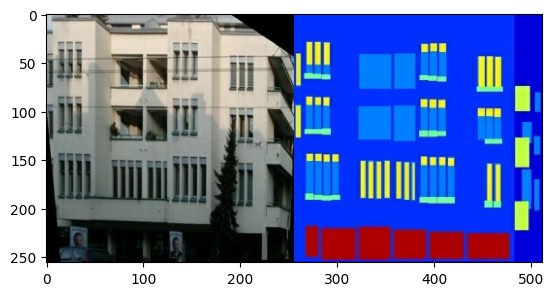

In [ ]:
plt.figure()
plt.imshow(sample_image)

In [ ]:
#checking number of images within the dataset

def count_images_in_dataset(dataset_path):
    num_images = 0
    # The dataset directory
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Check if the file has an image extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                num_images += 1
    return num_images

dataset_name = "facades"
_PATH = path_to_zip.parent / dataset_name
num_images = count_images_in_dataset(_PATH)
print("Number of images in the dataset:", num_images)

NameError: name 'path_to_zip' is not defined

Here the "building facade images" are the real images and  "architecture label images" represent "masks" of the images

**3)Splitting them into two seperate image tensor files, by using slicing operation.**

This is done by assuming that for each image the real and  mask image are given together. So by taking its width and splitting it into two seperates the real image and the mask image. With the help of chatgpt, I modified the code so that it could do it for all images, not just for one image as shown in the notebook.

In [ ]:
  def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

    #The following part is redundant and gets overwritten in the following block of code. I have kept this to keep track of my notebook :)

def load_images(_PATH):
    # List all files in the dataset directory
    image_files = os.listdir(_PATH)

    # Initialize lists to store preprocessed images
    input_images = []
    real_images = []

    # Iterate over each image file in the dataset
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(dataset_dir, image_file)

        # Load and preprocess the image using the load() function
        input_image, real_image = load(image_path)

        # Append the preprocessed images to the lists
        input_images.append(input_image)
        real_images.append(real_image)

    return input_images, real_images


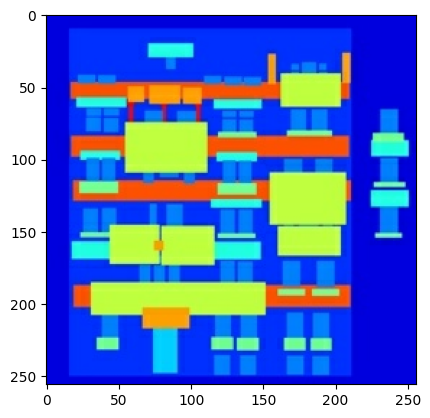

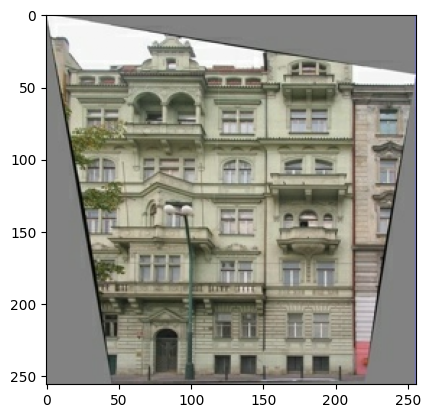

In [ ]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)


In [ ]:
def load_images_from_directory(dataset_path):
    # Initialize lists to store preprocessed images
    input_images = []
    real_images = []

    # Iterate over all files and directories in the dataset directory
    for root, dirs, files in os.walk(dataset_path):  # Recursively traverse directory
        for file in files:
            # Check if the file has an image extension
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                # Load and preprocess the image using the load() function
                input_image, real_image = load(os.path.join(root, file))

                # Append the preprocessed images to the lists
                input_images.append(input_image)
                real_images.append(real_image)

    return input_images, real_images

# Call the function to load images from the dataset directory
original_images, mask_images = load_images_from_directory(str(PATH / 'train'))


In [ ]:
image_files = os.listdir(_PATH)
print(image_files)


NameError: name 'os' is not defined

**4)Preprocessing**

To preprocess the data, the paper uses random jittering and mirroring to achieve that. We call these processess in the form of functions.

In [ ]:
# Define the dataset directory path
dataset_dir = 'PATH'

# Load images from the dataset directory
input_images, real_images = load_images_from_directory(str(PATH / 'train'))

# Determine the number of images in the dataset
num_images = len(input_images)

# Set the buffer size to the number of images in the dataset
BUFFER_SIZE = num_images

# Define the other constants
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Define the functions for image preprocessing
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


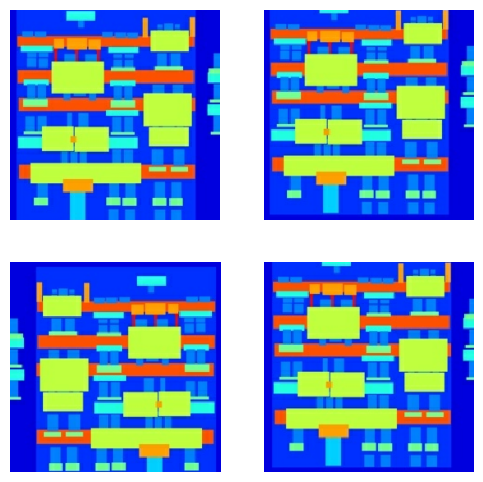

In [ ]:
#to check
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

**5)Building an input pipeline with tf.data**

In [ ]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image


In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
#similarly spitting data into test dataset
test_dataset_dir = str(PATH / 'test/*.jpg')
test_dataset = tf.data.Dataset.list_files(test_dataset_dir)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


**6) Building the generator (U-Net)**



It consists of an encoder-decoder structure with skip connections between corresponding layers of the encoder and decoder. These skip connections help preserve spatial information and enable the generator to better capture details from the input image. The encoder downsamples the input image to extract features, while the decoder upsamples these features to generate the output image. The skip connections allow the decoder to access high-resolution information from earlier layers of the encoder, aiding in the reconstruction of fine details.

Each block in the encoder is:

 1.Convolution  

 2.Batch normalization

 3.Leaky ReLU

Each block in the decoder is:

1.Transposed convolution

2.Batch normalization

3.Dropout (applied to the first 3 blocks)

4.ReLU

**Encoder**

In [ ]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Combining upsampler and downsampler

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualizing the model

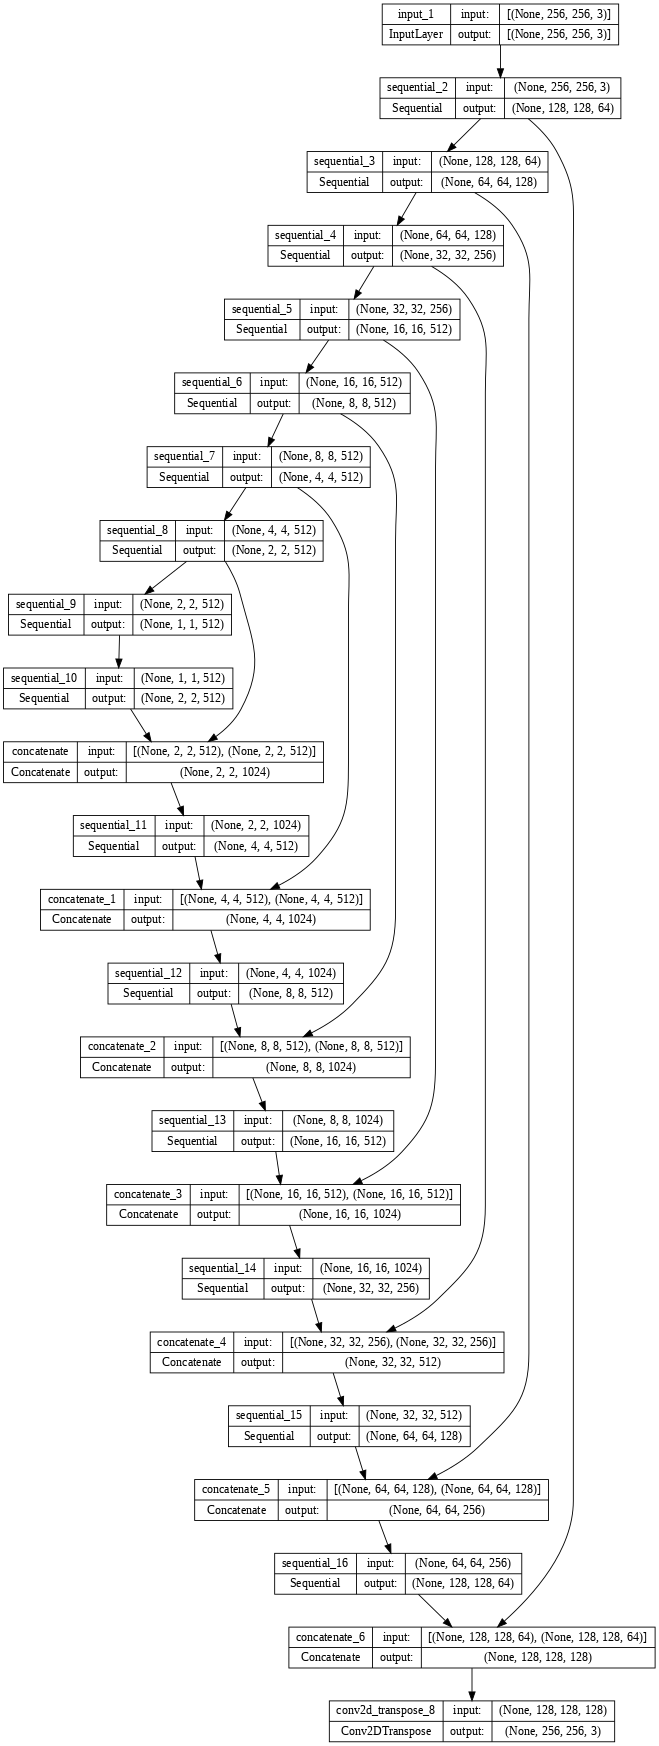

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Testing the generator

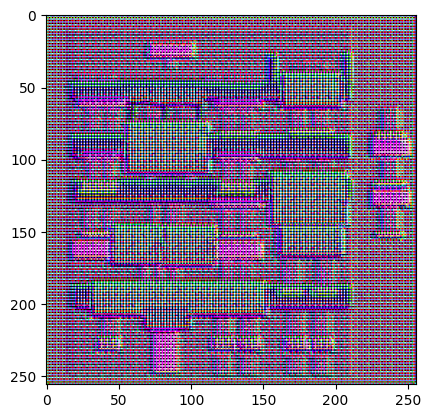

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

Defining Loss function

As defined by the paper, the formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100.

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**7)Building the discriminator**

It  uses a PatchGAN discriminator, which evaluates patches of the image. This  helps in providing detailed feedback to the generator by analyzing its structures. The discriminator assigns probabilities to each patch of the input images, indicating how real or fake they appear. By analyzing multiple patches across the image, the discriminator can provide feedback on the how realistic each region is, guiding the generator to produce more convincing images.

Each block in the discriminator is:

Convolution

Batch normalization

Leaky ReLU.

The discriminator receives 2 inputs:

The input image and the ground truth image, which it should classify as real.

The input image and the generated image  which it should classify as fake.

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualizing discriminator

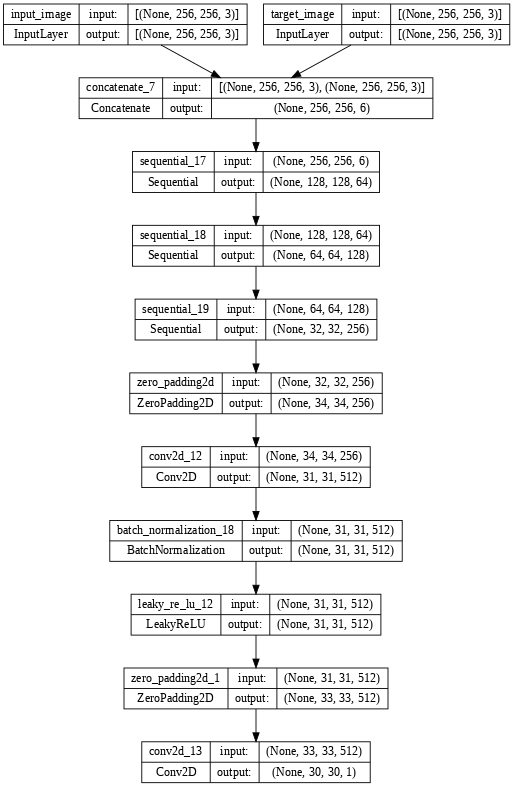

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Testing the discriminator

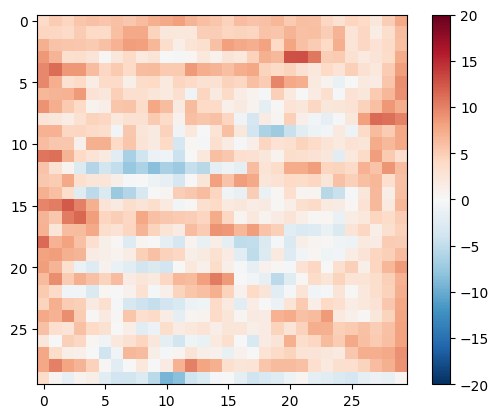

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

The discriminator_loss function takes two inputs from real images and generated images.
real_loss is a cross-entropy loss of the real images and an array of ones(these are the real images).
generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros these are the fake images).
The total_loss is the sum of real_loss and generated_loss.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Define the optimizers and a checkpoint-saver(tf.train.Checkpoint)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**8)Generating images**

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# Get all local variables
local_variables = locals()

# Filter out datasets from local variables
datasets = [var_name for var_name, var_value in local_variables.items() if isinstance(var_value, tf.data.Dataset)]

# Print the names of the datasets
print("Names of datasets:")
for dataset_name in datasets:
    print(dataset_name)


Names of datasets:
train_dataset
test_dataset


Testing the function

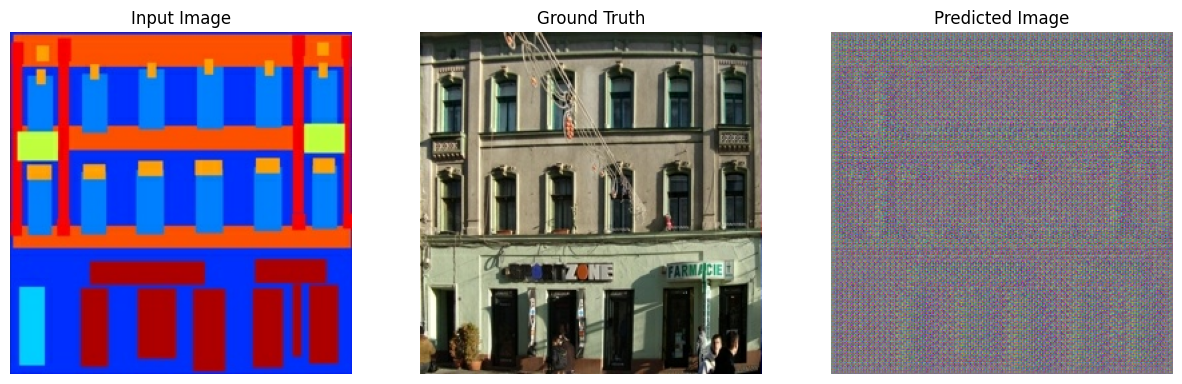

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

**9)Training**

First, the discriminator will recieve input and generated image. Next, it will recieve the input and ground truth image.Then, generator and discrimninator loss will be calculated.Then the gradients of those losses are applied to the Optimizer. Then the the losses are logged to TensorBoard which means values of different loss functions are recorded during the training process and then visualized using TensorBoard

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

Here,every 10 steps print a dot.
Every 1000 steps: clears the display and runs generate_images to show the progress.
Every 5000 steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5000 steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 96.92 sec



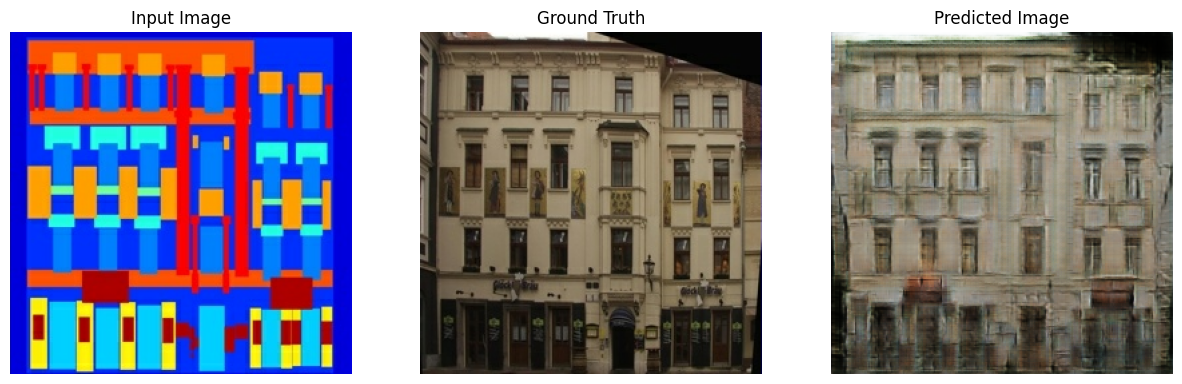

Step: 39k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
!ls {checkpoint_dir}
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint		    ckpt-3.index		ckpt-6.index
ckpt-1.data-00000-of-00001  ckpt-4.data-00000-of-00001	ckpt-7.data-00000-of-00001
ckpt-1.index		    ckpt-4.index		ckpt-7.index
ckpt-2.data-00000-of-00001  ckpt-5.data-00000-of-00001	ckpt-8.data-00000-of-00001
ckpt-2.index		    ckpt-5.index		ckpt-8.index
ckpt-3.data-00000-of-00001  ckpt-6.data-00000-of-00001


10)Generating some images

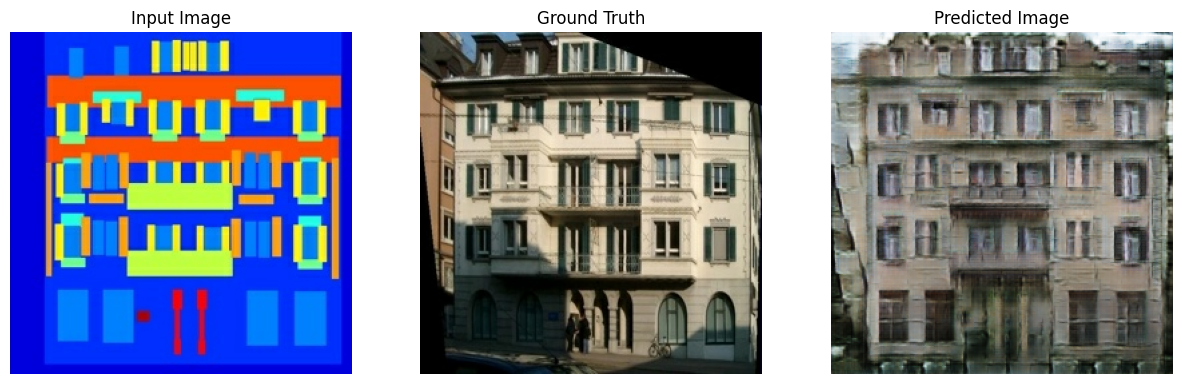

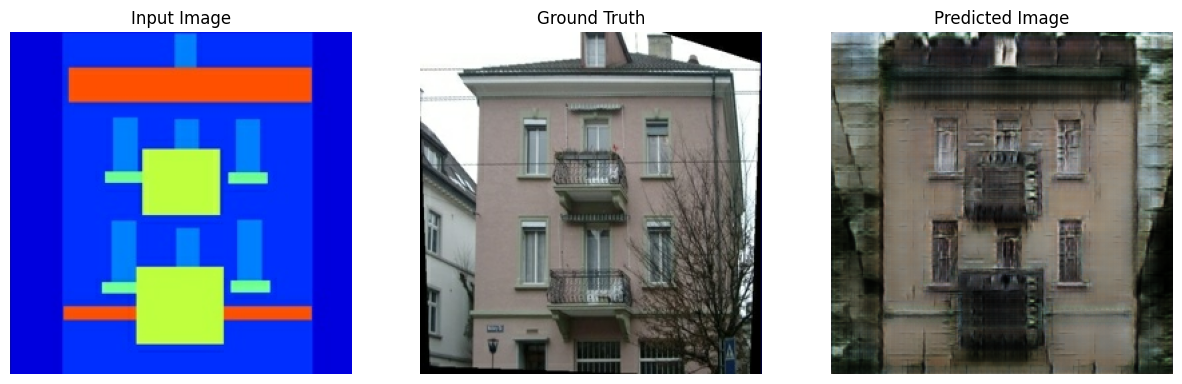

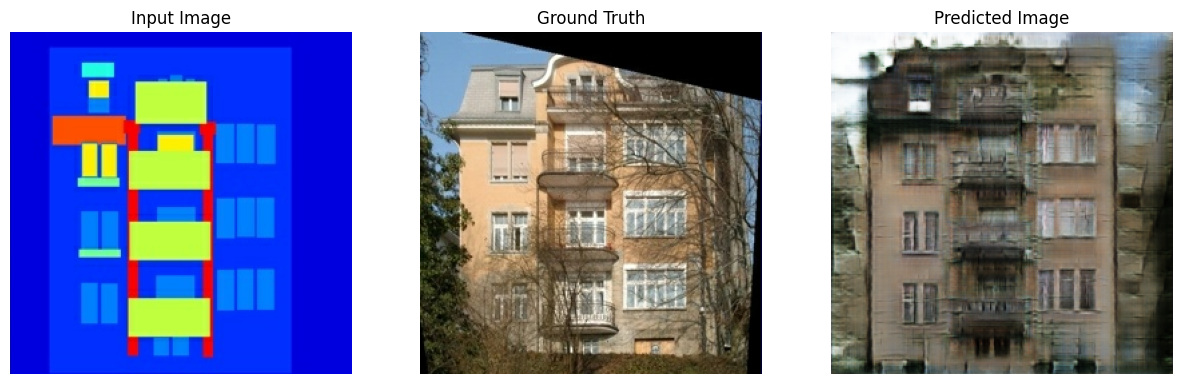

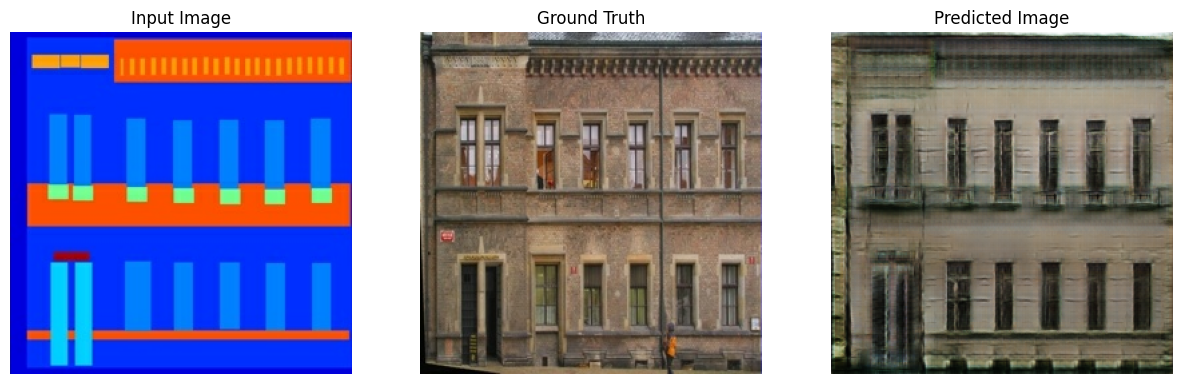

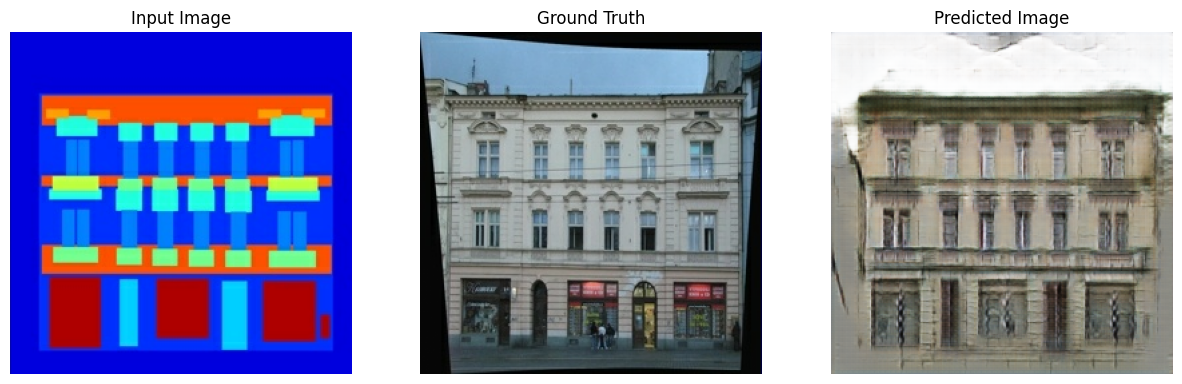

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)